Model Accuracy: 86.97%


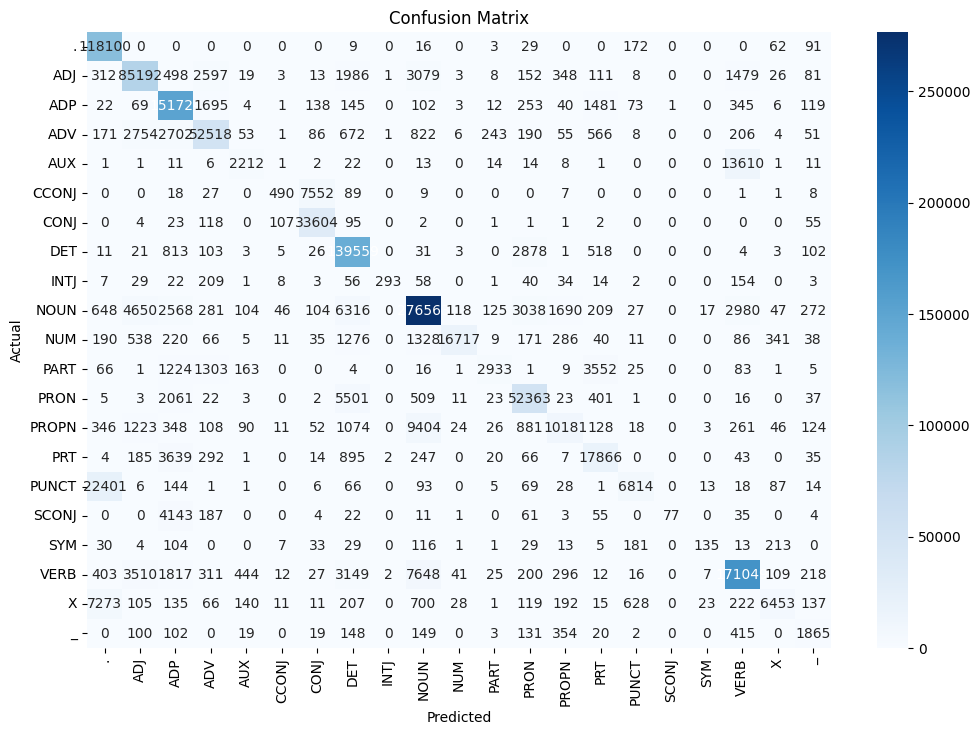

In [10]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the dataset
train_file = "train_data.csv"
test_file = "validation_data.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Data Processing
def process_data(data):
    sentences = []
    for row in data.iloc[:, 0]:  # Assuming the first column has sentence strings
        sentence = ast.literal_eval(row)  # Convert string to list of tuples
        sentences.append(sentence)
    return sentences

train_sentences = process_data(train_data)
test_sentences = process_data(test_data)

# Extract vocabulary and tags
vocab = set(word for sentence in train_sentences for word, _ in sentence)
tags = set(tag for sentence in train_sentences for _, tag in sentence)

# Initialize probability matrices
tag_counts = defaultdict(int)
transition_counts = defaultdict(lambda: defaultdict(int))
emission_counts = defaultdict(lambda: defaultdict(int))
initial_counts = defaultdict(int)

# Compute probabilities
for sentence in train_sentences:
    prev_tag = None
    for word, tag in sentence:
        tag_counts[tag] += 1
        emission_counts[tag][word] += 1

        if prev_tag:
            transition_counts[prev_tag][tag] += 1
        else:
            initial_counts[tag] += 1  # First word tag

        prev_tag = tag

# Convert counts to probabilities
total_sentences = len(train_sentences)
initial_probs = {tag: (initial_counts[tag] + 1) / (total_sentences + len(tags)) for tag in tags}

transition_probs = {tag: {next_tag: (transition_counts[tag][next_tag] + 1) / (tag_counts[tag] + len(tags)) for next_tag in tags} for tag in tags}

emission_probs = {tag: {word: (emission_counts[tag][word] + 1) / (tag_counts[tag] + len(vocab)) for word in vocab} for tag in tags}

# Viterbi Algorithm Implementation
def viterbi(sentence):
    viterbi_matrix = [{}]
    backpointer = [{}]

    for tag in tags:
        viterbi_matrix[0][tag] = initial_probs.get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[0], 1e-6)
        backpointer[0][tag] = None

    for i in range(1, len(sentence)):
        viterbi_matrix.append({})
        backpointer.append({})
        for tag in tags:
            max_prob, prev_state = max((viterbi_matrix[i-1][prev_tag] * transition_probs[prev_tag].get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[i], 1e-6), prev_tag) for prev_tag in tags)
            viterbi_matrix[i][tag] = max_prob
            backpointer[i][tag] = prev_state

    best_last_tag = max(viterbi_matrix[-1], key=viterbi_matrix[-1].get)
    best_tags = [best_last_tag]

    for i in range(len(sentence)-1, 0, -1):
        best_tags.insert(0, backpointer[i][best_tags[0]])

    return best_tags

# Model Evaluation
actual_tags = []
predicted_tags = []

for sentence in test_sentences:
    words = [word for word, _ in sentence]
    true_tags = [tag for _, tag in sentence]
    pred_tags = viterbi(words)

    actual_tags.extend(true_tags)
    predicted_tags.extend(pred_tags)

# Compute accuracy
accuracy = sum(1 for a, p in zip(actual_tags, predicted_tags) if a == p) / len(actual_tags)
print(f"Model Accuracy: {accuracy:.2%}")

# Confusion Matrix
conf_matrix = pd.crosstab(pd.Series(actual_tags, name="Actual"), pd.Series(predicted_tags, name="Predicted"))
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()